In [1]:
import os
from pathlib import Path
from typing import List, Optional

import gcsfs
import google.auth
import numpy as np
import pandas as pd
import torch
import wandb
from google.colab import auth, output
from sklearn.metrics import accuracy_score
from torch import nn
from tqdm.notebook import tqdm


In [2]:
# connect to google cloud storage
# auth.authenticate_user()
#credentials, _ = google.auth.default()
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"
fs = gcsfs.GCSFileSystem(project="thesis")
fs_prefix = "gs://"

/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
features_classical_size = [
    'TRADE_PRICE', 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',
       'rel_ask_size_ex', 'TRADE_SIZE', 'bid_size_ex', 'ask_size_ex',
       'rel_ask_ex', 'rel_bid_ex', 'BEST_rel_bid', 'BEST_rel_ask',
       'bid_ask_ratio_ex', 'chg_ex_lead', 'chg_ex_lag', 'chg_all_lead',
       'chg_all_lag', 'ask_ex', 'bid_ex', 'BEST_ASK', 'BEST_BID',
       'price_all_lag', 'price_all_lead', 'price_ex_lag', 'price_ex_lead'
]

In [4]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
# for refs

run = wandb.init(project="thesis",entity="fbv")

dataset = "fbv/thesis/classical_size_features_log_normalized:v0"
artifact = run.use_artifact(dataset)
data_dir = artifact.download()

model = "fbv/thesis/3lfsbuby_TabTransformer_default_trial_82.pth:v0"
artifact = run.use_artifact(model)
model_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact classical_size_features_log_normalized:v0, 2564.04MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb:   1 of 1 files downloaded.  


In [5]:
X_test = pd.read_parquet(Path(data_dir, "test_set_20.parquet"), engine="fastparquet")

y_test = X_test["buy_sell"]
X_test = X_test[features_classical_size]


In [6]:
X_test.head()

,TRADE_PRICE,bid_ask_size_ratio_ex,rel_bid_size_ex,rel_ask_size_ex,TRADE_SIZE,bid_size_ex,ask_size_ex,rel_ask_ex,rel_bid_ex,BEST_rel_bid,...,chg_all_lead,chg_all_lag,ask_ex,bid_ex,BEST_ASK,BEST_BID,price_all_lag,price_all_lead,price_ex_lag,price_ex_lead
39342171,-0.886605,-0.999944,-0.999978,-0.999959,-0.920668,-0.397940,-0.568327,-0.450753,0.450753,-0.222609,...,0.979614,0.887864,-0.869878,-0.883935,-0.922989,-0.883936,-0.917824,-0.921640,-0.897066,-0.875702
39342172,-0.398830,-0.999980,-0.999660,-0.999773,-1.000000,-0.879588,-0.879588,-0.449826,0.449826,-0.221914,...,0.979609,0.887724,-0.387113,-0.403539,-0.637270,-0.403545,-0.511138,-0.615242,-0.380144,-0.521084
39342173,-0.060248,-0.999980,-0.999660,-0.999773,-1.000000,-0.879588,-0.879588,-0.450689,0.450689,-0.222561,...,0.979589,0.887492,-0.031559,-0.059053,-0.426840,-0.059063,-0.248786,-0.402171,-0.057769,-0.080426
39342174,-0.675788,-0.999980,-0.999966,-0.999977,-1.000000,-0.583443,-0.583443,-0.448436,0.448436,-0.220290,...,0.979647,0.887998,-0.673685,-0.709687,-0.811995,-0.709690,-0.802774,-0.914062,-1.000000,-1.000000
39342175,-0.727221,-0.999980,-0.999966,-0.999977,-1.000000,-0.583443,-0.583443,-0.450753,0.450753,-0.222609,...,0.979636,0.887758,-0.700498,-0.724674,-0.822743,-0.724677,-0.747425,-0.913006,-1.000000,-1.000000


## TabTransformer Baseline 🦾

In [7]:
import sys

sys.path.append("..")
from otc.models.tabtransformer import TabTransformer
from otc.data.dataset import TabDataset
from otc.data.dataloader import TabDataLoader

In [10]:
# https://wandb.ai/fbv/thesis/runs/4fmccjm7/files/wandb-summary.json
# https://wandb.ai/fbv/thesis/artifacts/model/3lfsbuby_TabTransformer_default_trial_82.pth/3a1937a3e6ec748d45a3/metadata
params = {  "dim": 32,
  "depth": 3,
  "heads": 2,
  "weight_decay": 0.00835620489462654,
  "lr": 0.0015514372468568292,
  "dropout": 0.1,
  "batch_size": 32768}

training_data = TabDataset(X_test, y_test, [], [])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")        

# differentiate between continous features only and mixed.
test_loader = TabDataLoader(
training_data.x_cat, training_data.x_cont, training_data.y, batch_size=params['batch_size'], device=device
)

       
model = TabTransformer(
            cat_cardinalities=[],
            num_continuous=len(features_classical_size),
            dim_out=1,
            mlp_act=nn.ReLU,
            dim=params["dim"],
            depth=params["depth"],
            heads=params["heads"],
            attn_dropout=params["dropout"],
            ff_dropout=params["dropout"],
            mlp_hidden_mults=(4, 2),
        ).to(device)


model.load_state_dict(torch.load(Path(model_dir,"3lfsbuby_TabTransformer_default_trial_82.pth")))
model.eval()

y_pred, y_true = [], []

for x_cat, x_cont, targets in test_loader:
  output = model(x_cat, x_cont)

  # map between zero and one, sigmoid is otherwise included in loss already
  # https://stackoverflow.com/a/66910866/5755604
  output = torch.sigmoid(output.squeeze())
  y_pred.append(output.detach().cpu().numpy())
  y_true.append(targets.detach().cpu().numpy())  # type: ignore

# round prediction to nearest int
y_pred = np.rint(np.concatenate(y_pred))
y_true = np.concatenate(y_true)

# map zeros back to -1
y_pred[y_pred == 0] = -1
y_true[y_true == 0] = -1

In [11]:
accuracy_score(y_true, y_pred)

0.672905426069829

In [12]:
# load default data to use unscaled version with all possible columns
test_orig = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_extended_20.parquet",
    engine="fastparquet",
)

/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [13]:
# Copy unscaled columns
X_print = test_orig.copy()

# add baseline results
X_print["rule"] = "Baseline"
X_print["buy_sell_predicted"] = y_pred

# prepare columns for printing
X_print["ttm"] = (
    X_print["EXPIRATION"].dt.to_period("M")
    - X_print["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)
X_print["year"] = X_print["QUOTE_DATETIME"].dt.year

bins_tradesize = [-np.inf, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
X_print["TRADE_SIZE_binned"] = pd.cut(
    X_print["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
X_print["year_binned"] = pd.cut(X_print["year"], bins_years, labels=year_labels)

bins_ttm = [-np.inf, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
X_print["ttm_binned"] = pd.cut(X_print["ttm"], bins_ttm, labels=ttm_labels)


bins_myn = [-np.inf, 0.7, 0.9, 1.1, 1.3, np.inf]
myn_labels = [
    "mny <=0.7",
    "mny (0.7-0.9]",
    "mny (0.9-1.1]",
    "mny (1.1-1.3]",
    "mny > 1.3",
]
X_print["myn_binned"] = pd.cut(X_print["myn"], bins_myn, labels=myn_labels)

X_print["issue_type_binned"] = X_print["issue_type"].replace(
    {"0": 'Stock options', 'A': 'Index options', '7': 'Others',
     'F': 'Others', '%': 'Others', ' ': 'Others'})


# TODO: time from previous trade; same underlying or any?


In [14]:
def check_robustness(criterion: str = "year_binned") -> pd.DataFrame:
    """
    Check robustness of rules by calculating the accuracy for a given
    criterion and rules.

    Example:
    rule		Baseline
    TRADE_SIZE_binned
    (0,1]	  0.710966
    (1,3]	  0.717664
    (3,5]	  0.715195
    (5,11]	0.699428
    >11	  	0.688348

    Args:
        criterion (str, optional): criterion to check robustness for.
        Defaults to "year_binned".

    Returns:
        pd.DataFrame: DataFrame with accuracy of rules. Rule in columns and
        criterion values in rows.
    """

    # fill others randomly with equal weight for every class.
    X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
        lambda l: l if not np.isnan(l) else np.random.choice([-1, 1])
    )

    # cuculate average over columns if multiple subsets are combined
    results = (
        X_print.groupby(["rule", criterion])[["buy_sell", "buy_sell_predicted"]]
        .apply(lambda x: accuracy_score(x["buy_sell"], x["buy_sell_predicted"]))
        .unstack(level=0)
        .assign(avg=lambda x: x.mean(axis=1))
    )
    return results


In [15]:
check_robustness("year_binned")


rule,Baseline,avg
year_binned,,
2015,0.645190,0.645190
2016,0.676413,0.676413
2017,0.674097,0.674097


In [16]:
check_robustness("OPTION_TYPE")


rule,Baseline,avg
OPTION_TYPE,,
C,0.675753,0.675753
P,0.669654,0.669654


In [17]:
check_robustness("issue_type_binned")

rule,Baseline,avg
issue_type_binned,,
Index options,0.524634,0.524634
Others,0.702792,0.702792
Stock options,0.663093,0.663093


In [18]:
check_robustness("TRADE_SIZE_binned")


rule,Baseline,avg
TRADE_SIZE_binned,,
"(0,1]",0.683563,0.683563
"(1,3]",0.690546,0.690546
"(3,5]",0.688925,0.688925
"(5,11]",0.653614,0.653614
>11,0.634339,0.634339


In [19]:
check_robustness("ttm_binned")


rule,Baseline,avg
ttm_binned,,
ttm <= 1 month,0.669447,0.669447
ttm (1-2] month,0.691056,0.691056
ttm (2-3] month,0.681317,0.681317
ttm (3-6] month,0.675536,0.675536
ttm (6-12] month,0.675719,0.675719
ttm > 12 month,0.665156,0.665156


In [20]:
check_robustness("myn_binned")


rule,Baseline,avg
myn_binned,,
mny <=0.7,0.665539,0.665539
mny (0.7-0.9],0.665949,0.665949
mny (0.9-1.1],0.683752,0.683752
mny (1.1-1.3],0.626057,0.626057
mny > 1.3,0.603918,0.603918


## Shap attributions

In [69]:
import shap

In [123]:
class TabModel:
    
    def __init__(self,model):
        self._model = model
        
    
    def predict(self,X:np.ndarray):
        

        
        # TODO: infer correct cat columns
        X = pd.DataFrame(X)
        y = pd.Series(range(len(X)))
        test_data = TabDataset(X, y, [], [])

        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")        

        # differentiate between continous features only and mixed.
        sample_loader = TabDataLoader(
        test_data.x_cat, test_data.x_cont, batch_size=params['batch_size'], device=device
        )

        y_pred= []

        for x_cat, x_cont in sample_loader:
          output = self._model(x_cat, x_cont)

          # map between zero and one, sigmoid is otherwise included in loss already
          # https://stackoverflow.com/a/66910866/5755604
          output = torch.sigmoid(output.squeeze())
          y_pred.append(output.detach().cpu().numpy())

        # get probabilities
        return y_pred[0].reshape(-1,1)

In [124]:
def get_probilistic_predictions(model, X):
    #X_sample = X_test.sample(n=50)

    tabmodel = TabModel(model)
    return tabmodel.predict(X)
    

In [139]:
f = lambda x: get_probilistic_predictions(model, x)
X_sample = X_test.sample(n=50)

kernelshap = shap.KernelExplainer(f, shap.sample(X_test, 52));
shap_values = kernelshap.shap_values(X_sample, nsamples=256);  # nsamples = no. of feature coalitions
#print(shap_values.shape, shap_values.dtype)

shap_values

  0%|          | 0/50 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

[array([[ 0.44628912,  0.01191375,  0.        , ..., -0.02196888,
          0.        , -0.00792286],
        [ 0.22639358, -0.0367014 ,  0.08083702, ..., -0.03510106,
          0.02744904,  0.0633191 ],
        [-0.25610831,  0.        ,  0.        , ...,  0.02919581,
          0.        , -0.01127516],
        ...,
        [ 0.25891763,  0.02913972,  0.02278852, ...,  0.        ,
         -0.01200252, -0.03767283],
        [-0.01431246,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.24529249,  0.        , -0.01396425, ..., -0.02078385,
         -0.01523253, -0.01563378]])]

In [140]:
shap_values = pd.DataFrame(shap_values[0], columns=X_test.columns)

In [141]:
import matplotlib.pyplot as plt

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'


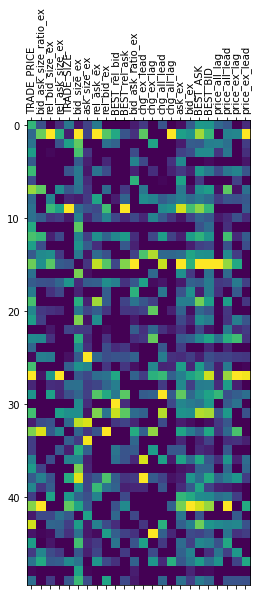

In [142]:
attrs_abs = np.abs(shap_values)
attrs_abs -= np.min(attrs_abs)
attrs_abs /= np.max(attrs_abs)
plt.ioff()
plt.matshow(attrs_abs)
plt.xticks(np.arange(len(X_test.columns)), X_test.columns, rotation=90)
plt.show()